$$ \beta\,(u-v) - \frac{d}{dx}\left(m_u\frac{du}{dx}\right) = f_1\qquad x\in\,(0,L)$$
$$ \beta\,(v-u) - \frac{d}{dx}\left(m_v\frac{dv}{dx}\right) = f_2\qquad x\in\,(0,L)$$

In [1]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.sparse import diags
import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import markers
import mylib

# import seaborn as sns
# sns.color_palette("dark")
# sns.set_theme(style="whitegrid")

def u_sol(x, kwargs):
    return kwargs['N'] + kwargs['O']*np.sin(kwargs['P']*(x-kwargs['Q']))

def dudx_sol(x, kwargs):
    return kwargs['O']*kwargs['P']*np.cos(kwargs['P']*(x-kwargs['Q']))

def d2udx2_sol(x, kwargs):
    return -kwargs['O']*np.square(kwargs['P'])*np.sin(kwargs['P']*(x-kwargs['Q']))


def v_sol(x, kwargs):
    return kwargs['R'] + kwargs['S']*np.exp(-kwargs['T']*x)

def dvdx_sol(x, kwargs):
    return -kwargs['S']*kwargs['T']*np.exp(-kwargs['T']*x)

def d2vdx2_sol(x, kwargs):
    return kwargs['S']*np.square(kwargs['T'])*np.exp(-kwargs['T']*x)


def m_u(x, kwargs):
    return kwargs['D'] + kwargs['E']*np.sin(kwargs['F']*(x-kwargs['G']))

def dm_udx(x, kwargs):
    return kwargs['E']*kwargs['F']*np.cos(kwargs['F']*(x-kwargs['G']))


def m_v(x, kwargs):
    return kwargs['H'] + kwargs['I']*np.sin(kwargs['L']*(x-kwargs['M']))

def dm_vdx(x, kwargs):
    return kwargs['I']*kwargs['L']*np.cos(kwargs['L']*(x-kwargs['M']))


def f_1(x, kwargs):
    return kwargs['beta']*(u_sol(x, kwargs)-v_sol(x, kwargs)) - (dm_udx(x, kwargs)*dudx_sol(x, kwargs) + m_u(x, kwargs)*d2udx2_sol(x, kwargs))

def f_2(x, kwargs):
    return kwargs['beta']*(v_sol(x, kwargs)-u_sol(x, kwargs)) - (dm_vdx(x, kwargs)*dvdx_sol(x, kwargs) + m_v(x, kwargs)*d2vdx2_sol(x, kwargs))

cond(Z) = 26650.074713007925
monolithic error = 2.6795751593555026e-08
{'type': 'dirichlet', 'value': 0.0}
{'type': 'dirichlet', 'value': -2.4492935982947064e-16}
{'type': 'dirichlet', 'value': 1.0}
{'type': 'dirichlet', 'value': 0.0018674427317079893}


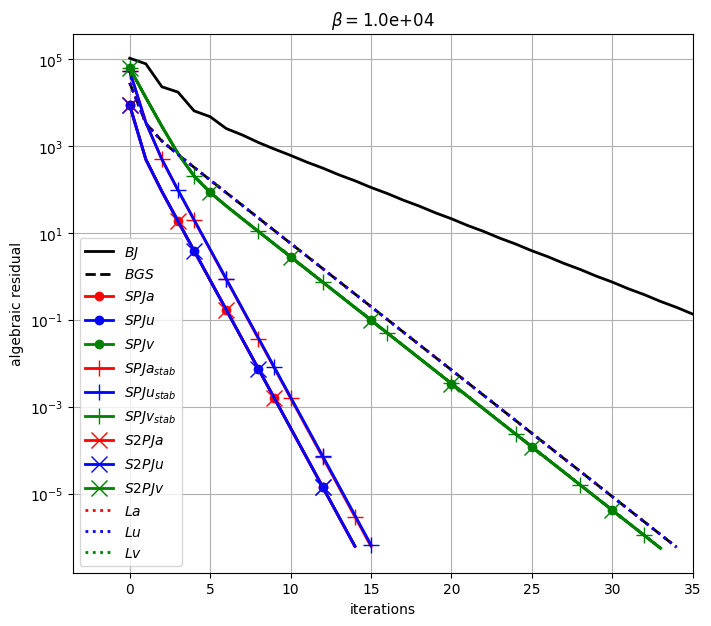

In [25]:
L = np.pi
N = 128
x = np.linspace(0, L, N+1) #faces coordinates
xc = np.linspace(0.5*np.divide(L, N), L-0.5*np.divide(L, N), N) #centercells coordinates
xfine = np.linspace(0, L, 1000)
omega = 1.5 # SOR relaxation factor
nit_max = 100
toll = 1e-6

kwargs = {
    'beta': 1e4,

    # m_u and m_v 
    'D': 1e4, #constant
    'E': 5e3, #amplitude
    'F': 2.0, #frequency
    'G': 0.0, #shift

    'H': 1.0, #1000.0, #constant
    'I': 0.5, #-999.999, #amplitude
    'L': 4.0, #frequency
    'M': 0.0, #shift

    # solutions      u(x) = N + O*sin(P*(x-Q))      v(x) = R + S*exp(-T*x)
    'N': 0.0,
    'O': 1.0,
    'P': 2.0,
    'Q': 0.0,

    'R': 0.0,
    'S': 1.0,
    'T': 2.0
}

leftBC_u  = {'type':'dirichlet', 'value':u_sol(0.0, kwargs)}
leftBC_v  = {'type':'dirichlet', 'value':v_sol(0.0, kwargs)}
rightBC_u = {'type':'dirichlet', 'value':u_sol(L, kwargs)}
rightBC_v = {'type':'dirichlet', 'value':v_sol(L, kwargs)}

A_laplacian, f1BC = mylib.fvm_laplacian_1D(m_u, leftBC_u, rightBC_u, N, L, kwargs)
D_laplacian, f2BC = mylib.fvm_laplacian_1D(m_v, leftBC_v, rightBC_v, N, L, kwargs)
A = sparse.csc_matrix( kwargs['beta']*sparse.eye(N) - A_laplacian)
B = sparse.csc_matrix(-kwargs['beta']*sparse.eye(N))
C = sparse.csc_matrix(-kwargs['beta']*sparse.eye(N))
D = sparse.csc_matrix( kwargs['beta']*sparse.eye(N) - D_laplacian)

f1 = f_1(xc, kwargs) - f1BC
f2 = f_2(xc, kwargs) - f2BC

Z = np.zeros((2*N,2*N))
Z[:N,:N] = A.toarray()
Z[:N,N:] = B.toarray()
Z[N:,:N] = C.toarray()
Z[N:,N:] = D.toarray()
Z = sparse.csc_matrix(Z)
f = np.concatenate((f1,f2))

solution = sparse.linalg.spsolve(Z, f)
u = solution[:N]
v = solution[N:]
u_rec = mylib.fvm_reconstruct_1D(u)
v_rec = mylib.fvm_reconstruct_1D(v)

u_BJ,   v_BJ,   res_BJ,   nitfinal_BJ   = mylib.method_BlockJacobi(                 A, B, C, D, f1, f2, nit_max, toll)
u_BGS,  v_BGS,  res_BGS,  nitfinal_BGS  = mylib.method_BlockGaussSeidel(            A, B, C, D, f1, f2, nit_max, toll)
u_SPJa, v_SPJa, res_SPJa, nitfinal_SPJa = mylib.method_ShurPartialJacobi(           A, B, C, D, f1, f2, nit_max, toll, type='alternate')
u_SPJu, v_SPJu, res_SPJu, nitfinal_SPJu = mylib.method_ShurPartialJacobi(           A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
u_SPJv, v_SPJv, res_SPJv, nitfinal_SPJv = mylib.method_ShurPartialJacobi(           A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')
u_SPJa_stab, v_SPJa_stab, res_SPJa_stab, nitfinal_SPJa_stab = mylib.method_SPJ_stab(A, B, C, D, f1, f2, nit_max, toll, type='alternate')
u_SPJu_stab, v_SPJu_stab, res_SPJu_stab, nitfinal_SPJu_stab = mylib.method_SPJ_stab(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
u_SPJv_stab, v_SPJv_stab, res_SPJv_stab, nitfinal_SPJv_stab = mylib.method_SPJ_stab(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')
u_SPJa, v_S2PJa, res_S2PJa, nitfinal_S2PJa = mylib.method_ShurDualPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='alternate')
u_SPJu, v_S2PJu, res_S2PJu, nitfinal_S2PJu = mylib.method_ShurDualPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
u_SPJv, v_S2PJv, res_S2PJv, nitfinal_S2PJv = mylib.method_ShurDualPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')
u_La,   v_La,   res_La,   nitfinal_La   = mylib.method_Lscheme(                     A, B, C, D, f1, f2, nit_max, toll, type="both",   Lu=0, Lv=0)
u_Lu,   v_Lu,   res_Lu,   nitfinal_Lu   = mylib.method_Lscheme(                     A, B, C, D, f1, f2, nit_max, toll, type="L_on_u", Lu=0, Lv=0)
u_Lv,   v_Lv,   res_Lv,   nitfinal_Lv   = mylib.method_Lscheme(                     A, B, C, D, f1, f2, nit_max, toll, type="L_on_v", Lu=0, Lv=0)


Z = Z.toarray()
mats = [A.toarray(), B.toarray(), C.toarray(), D.toarray()]
mats_names = ['A','B','C','D']

print("cond(Z) =", np.linalg.cond(Z))
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z, solution))}")
print(leftBC_u)
print(rightBC_u)
print(leftBC_v)
print(rightBC_v)

linewidth = 2
markersize = 6
markevery = 1
# plt.matshow(Z, aspect='equal')

plt.figure(figsize=(8,7), dpi=100)
nn = 5
plt.semilogy(res_BJ,        'k',  linestyle='solid',  label=r"$BJ$",          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)
plt.semilogy(res_BGS,       'k',  linestyle='dashed', label=r"$BGS$",         linewidth=linewidth, markersize=markersize,   markevery=markevery+1)
plt.semilogy(res_SPJa,      'ro', linestyle='solid',  label=r"$SPJa$",        linewidth=linewidth, markersize=markersize,   markevery=markevery+2)
plt.semilogy(res_SPJu,      'bo', linestyle='solid',  label=r"$SPJu$",        linewidth=linewidth, markersize=markersize,   markevery=markevery+3)
plt.semilogy(res_SPJv,      'go', linestyle='solid',  label=r"$SPJv$",        linewidth=linewidth, markersize=markersize,   markevery=markevery+4)
plt.semilogy(res_SPJa_stab, 'r+', linestyle='solid',  label=r"$SPJa_{stab}$", linewidth=linewidth, markersize=2*markersize, markevery=markevery+1)
plt.semilogy(res_SPJu_stab, 'b+', linestyle='solid',  label=r"$SPJu_{stab}$", linewidth=linewidth, markersize=2*markersize, markevery=markevery+2)
plt.semilogy(res_SPJv_stab, 'g+', linestyle='solid',  label=r"$SPJv_{stab}$", linewidth=linewidth, markersize=2*markersize, markevery=markevery+3)
plt.semilogy(res_S2PJa,     'rx', linestyle='solid',  label=r"$S2PJa$",       linewidth=linewidth, markersize=2*markersize, markevery=markevery+2)
plt.semilogy(res_S2PJu,     'bx', linestyle='solid',  label=r"$S2PJu$",       linewidth=linewidth, markersize=2*markersize, markevery=markevery+3)
plt.semilogy(res_S2PJv,     'gx', linestyle='solid',  label=r"$S2PJv$",       linewidth=linewidth, markersize=2*markersize, markevery=markevery+4)
plt.semilogy(res_La,         'r', linestyle='dotted', label=r"$La$",          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)
plt.semilogy(res_Lu,         'b', linestyle='dotted', label=r"$Lu$",          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)
plt.semilogy(res_Lv,         'g', linestyle='dotted', label=r"$Lv$",          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)

plt.legend()
plt.grid()
plt.xlabel('iterations')
plt.ylabel('algebraic residual')
plt.title(r'$\beta = ${:.1e}'.format(kwargs['beta']))
plt.xlim(right=35)

# plt.savefig('figures/dualporosity_aresidual.pdf')
plt.show()

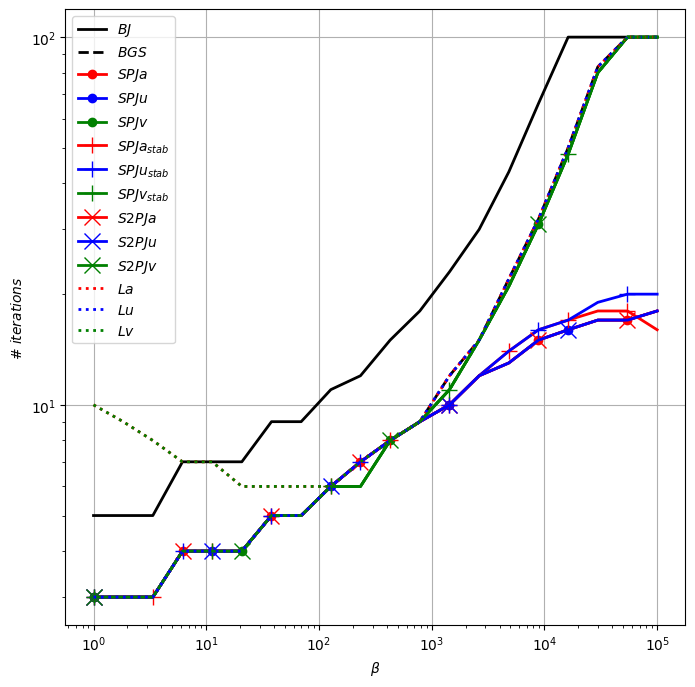

In [27]:

L = np.pi
N = 128
x = np.linspace(0, L, N+1) #faces coordinates
xc = np.linspace(0.5*np.divide(L, N), L-0.5*np.divide(L, N), N) #centercells coordinates
xfine = np.linspace(0, L, 1000)
# omega = 1.5 # SOR relaxation factor
nit_max = 100
toll = 1e-6

err = {
    "BJ":       {"nit":[], "u_errl2":[], "v_errl2":[]},
    "BGS":      {"nit":[], "u_errl2":[], "v_errl2":[]},
    "BSOR":     {"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJa":     {"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJu":     {"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJv":     {"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJa_stab":{"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJu_stab":{"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJv_stab":{"nit":[], "u_errl2":[], "v_errl2":[]},
    "S2PJa":    {"nit":[], "u_errl2":[], "v_errl2":[]},
    "S2PJu":    {"nit":[], "u_errl2":[], "v_errl2":[]},
    "S2PJv":    {"nit":[], "u_errl2":[], "v_errl2":[]},
    "La":       {"nit":[], "u_errl2":[], "v_errl2":[]},
    "Lu":       {"nit":[], "u_errl2":[], "v_errl2":[]},
    "Lv":       {"nit":[], "u_errl2":[], "v_errl2":[]},
    "mono":     {"u_errl2":[], "v_errl2":[]}
    }

# fig1, axs1 = plt.subplots(2, 1, figsize=(5,5), dpi=100, sharex=True)
# fig1, axs1 = plt.subplots(1, 1, figsize=(5,3), dpi=100)
fig2, axs2 = plt.subplots(1, 1, figsize=(8,8), dpi=100)
# fig3, axs3 = plt.subplots(1, 1, figsize=(5,5), dpi=100)
# axs1.xaxis.set_major_formatter(plt.FuncFormatter(mylib.format_func))
# axs1.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))

linewidth = 2
markersize = 6
markevery = 1

beta = np.logspace(0, 5, 20)
# beta = [0.001]
for val in beta:
    kwargs = {
        'beta': val,

        # m_u and m_v 
        'D': 1e4, #constant
        'E': 5e3, #amplitude
        'F': 2.0, #frequency
        'G': 0.0, #shift

        'H': 1,#1000.0, #constant
        'I': 0.5,#-999.999, #amplitude
        'L': 4, #frequency
        'M': 0.0, #shift

        # solutions
        'N': 0,
        'O': 1,
        'P': 2,
        'Q': 0.0,

        'R': 0,
        'S': 1.0,
        'T': 2.0
    }  

    leftBC_u  = {'type':'dirichlet', 'value':u_sol(0.0, kwargs)} #'type':'neumann',
    rightBC_u = {'type':'dirichlet', 'value':u_sol(L, kwargs)}
    leftBC_v  = {'type':'dirichlet', 'value':v_sol(0.0, kwargs)}
    rightBC_v = {'type':'dirichlet', 'value':v_sol(L, kwargs)}

    A_laplacian, f1BC = mylib.fvm_laplacian_1D(m_u, leftBC_u, rightBC_u, N, L, kwargs)
    D_laplacian, f2BC = mylib.fvm_laplacian_1D(m_v, leftBC_v, rightBC_v, N, L, kwargs)
    A = sparse.csc_matrix( kwargs['beta']*sparse.eye(N) - A_laplacian)
    B = sparse.csc_matrix(-kwargs['beta']*sparse.eye(N))
    C = sparse.csc_matrix(-kwargs['beta']*sparse.eye(N))
    D = sparse.csc_matrix( kwargs['beta']*sparse.eye(N) - D_laplacian)

    f1 = f_1(xc, kwargs) - f1BC
    f2 = f_2(xc, kwargs) - f2BC

    Z = np.zeros((2*N,2*N))
    Z[:N,:N] = A.toarray()
    Z[:N,N:] = B.toarray()
    Z[N:,:N] = C.toarray()
    Z[N:,N:] = D.toarray()
    Z = sparse.csc_matrix(Z)
    f = np.concatenate((f1,f2))
    
    solution = sparse.linalg.spsolve(Z, f)
    u = solution[:N]
    v = solution[N:]
    u_rec = mylib.fvm_reconstruct_1D(u)
    v_rec = mylib.fvm_reconstruct_1D(v)
    
    err['mono']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u)))
    err['mono']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v)))

    u_BJ,        v_BJ,        res_BJ,        nitfinal_BJ        = mylib.method_BlockJacobi(          A, B, C, D, f1, f2, nit_max, toll)
    u_BGS,       v_BGS,       res_BGS,       nitfinal_BGS       = mylib.method_BlockGaussSeidel(     A, B, C, D, f1, f2, nit_max, toll)
    u_SPJa,      v_SPJa,      res_SPJa,      nitfinal_SPJa      = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='alternate')
    u_SPJu,      v_SPJu,      res_SPJu,      nitfinal_SPJu      = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
    u_SPJv,      v_SPJv,      res_SPJv,      nitfinal_SPJv      = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')
    u_SPJa_stab, v_SPJa_stab, res_SPJa_stab, nitfinal_SPJa_stab = mylib.method_SPJ_stab(             A, B, C, D, f1, f2, nit_max, toll, type='alternate')
    u_SPJu_stab, v_SPJu_stab, res_SPJu_stab, nitfinal_SPJu_stab = mylib.method_SPJ_stab(             A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
    u_SPJv_stab, v_SPJv_stab, res_SPJv_stab, nitfinal_SPJv_stab = mylib.method_SPJ_stab(             A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')
    u_S2PJa,     v_S2PJa,     res_S2PJa,     nitfinal_S2PJa     = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll, type='alternate')
    u_S2PJu,     v_S2PJu,     res_S2PJu,     nitfinal_S2PJu     = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
    u_S2PJv,     v_S2PJv,     res_S2PJv,     nitfinal_S2PJv     = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')
    u_La,        v_La,        res_La,        nitfinal_La        = mylib.method_Lscheme(              A, B, C, D, f1, f2, nit_max, toll, type="both",   Lu=0.5, Lv=0.5)
    u_Lu,        v_Lu,        res_Lu,        nitfinal_Lu        = mylib.method_Lscheme(              A, B, C, D, f1, f2, nit_max, toll, type="L_on_u", Lu=0.5, Lv=0.5)
    u_Lv,        v_Lv,        res_Lv,        nitfinal_Lv        = mylib.method_Lscheme(              A, B, C, D, f1, f2, nit_max, toll, type="L_on_v", Lu=0.5, Lv=0.5)

######################################

    Z = Z.toarray()
    A = A.toarray()
    B = B.toarray()
    C = C.toarray()
    D = D.toarray()

    err['BJ']['nit'].append(nitfinal_BJ)
    err['BJ']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_BJ)))
    err['BJ']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_BJ)))
    err['BGS']['nit'].append(nitfinal_BGS)
    err['BGS']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_BGS)))
    err['BGS']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_BGS)))
    err['SPJa']['nit'].append(nitfinal_SPJa)
    err['SPJa']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJa)))
    err['SPJa']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJa)))
    err['SPJu']['nit'].append(nitfinal_SPJu)
    err['SPJu']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJu)))
    err['SPJu']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJu)))
    err['SPJv']['nit'].append(nitfinal_SPJv)
    err['SPJv']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJv)))
    err['SPJv']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJv)))
    err['SPJa_stab']['nit'].append(nitfinal_SPJa_stab)
    err['SPJa_stab']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJa_stab)))
    err['SPJa_stab']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJa_stab)))
    err['SPJu_stab']['nit'].append(nitfinal_SPJu_stab)
    err['SPJu_stab']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJu_stab)))
    err['SPJu_stab']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJu_stab)))
    err['SPJv_stab']['nit'].append(nitfinal_SPJv_stab)
    err['SPJv_stab']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJv_stab)))
    err['SPJv_stab']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJv_stab)))
    err['S2PJa']['nit'].append(nitfinal_S2PJa)
    err['S2PJa']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_S2PJa)))
    err['S2PJa']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_S2PJa)))
    err['S2PJu']['nit'].append(nitfinal_S2PJu)
    err['S2PJu']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_S2PJu)))
    err['S2PJu']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_S2PJu)))
    err['S2PJv']['nit'].append(nitfinal_S2PJv)
    err['S2PJv']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_S2PJv)))
    err['S2PJv']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_S2PJv)))
    err['La']['nit'].append(nitfinal_La)
    err['La']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_La)))
    err['La']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_La)))
    err['Lu']['nit'].append(nitfinal_Lu)
    err['Lu']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_Lu)))
    err['Lu']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_Lu)))
    err['Lv']['nit'].append(nitfinal_Lv)
    err['Lv']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_Lv)))
    err['Lv']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_Lv)))

axs2.loglog(beta, err['BJ']['nit'],       'k',  linestyle='solid',  label=r"$BJ$",          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)
axs2.loglog(beta, err['BGS']['nit'],      'k',  linestyle='dashed', label=r"$BGS$",         linewidth=linewidth, markersize=markersize,   markevery=markevery+1)
axs2.loglog(beta, err['SPJa']['nit'],     'ro', linestyle='solid',  label=r"$SPJa$",        linewidth=linewidth, markersize=markersize,   markevery=markevery+2)
axs2.loglog(beta, err['SPJu']['nit'],     'bo', linestyle='solid',  label=r"$SPJu$",        linewidth=linewidth, markersize=markersize,   markevery=markevery+3)
axs2.loglog(beta, err['SPJv']['nit'],     'go', linestyle='solid',  label=r"$SPJv$",        linewidth=linewidth, markersize=markersize,   markevery=markevery+4)
axs2.loglog(beta, err['SPJa_stab']['nit'],'r+', linestyle='solid',  label=r"$SPJa_{stab}$", linewidth=linewidth, markersize=2*markersize, markevery=markevery+1)
axs2.loglog(beta, err['SPJu_stab']['nit'],'b+', linestyle='solid',  label=r"$SPJu_{stab}$", linewidth=linewidth, markersize=2*markersize, markevery=markevery+2)
axs2.loglog(beta, err['SPJv_stab']['nit'],'g+', linestyle='solid',  label=r"$SPJv_{stab}$", linewidth=linewidth, markersize=2*markersize, markevery=markevery+3)
axs2.loglog(beta, err['S2PJa']['nit'],    'rx', linestyle='solid',  label=r'$S2PJa$',       linewidth=linewidth, markersize=2*markersize, markevery=markevery+2)
axs2.loglog(beta, err['S2PJu']['nit'],    'bx', linestyle='solid',  label=r'$S2PJu$',       linewidth=linewidth, markersize=2*markersize, markevery=markevery+3)
axs2.loglog(beta, err['S2PJv']['nit'],    'gx', linestyle='solid',  label=r'$S2PJv$',       linewidth=linewidth, markersize=2*markersize, markevery=markevery+4)
axs2.loglog(beta, err['La']['nit'],        'r', linestyle='dotted', label=r'$La$',          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)
axs2.loglog(beta, err['Lu']['nit'],        'b', linestyle='dotted', label=r'$Lu$',          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)
axs2.loglog(beta, err['Lv']['nit'],        'g', linestyle='dotted', label=r'$Lv$',          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)
axs2.set_xlabel(r"$\beta$")
axs2.set_ylabel(r"$\#~iterations$")
axs2.grid()
axs2.legend()
fig2.savefig('./figures/dp_1D_beta_it_100_1e-6.pdf')

# axs3.loglog(beta, err['mono']['u_errl2'], 's-', label=r'$Monolithic$')
# axs3.loglog(beta, err['BJ']['u_errl2'],   'k.-', label=r'$BJ$')
# axs3.loglog(beta, err['BGS']['u_errl2'],  'r.-', label=r'$BGS$')
# axs3.loglog(beta, err['SPJa']['u_errl2'], 'r>-', label=r'$SPJa$')
# axs3.loglog(beta, err['SPJu']['u_errl2'], 'b>-', label=r'$SPJu$')
# axs3.loglog(beta, err['SPJv']['u_errl2'], 'g>-', label=r'$SPJv$')
# axs3.loglog(beta, err['La']['u_errl2'],   'rP-', label=r'$La$')
# axs3.loglog(beta, err['Lu']['u_errl2'],   'bP-', label=r'$Lu$')
# axs3.loglog(beta, err['Lv']['u_errl2'],   'gP-', label=r'$Lv$')
# axs3.loglog(beta, err['S2PJ']['u_errl2'], 'k3-', label=r'$S2PJ$', markersize=10)
# axs3.set_xlabel(r"$\beta$")
# axs3.set_ylabel(r"$||u(x_f)-u_h(x_f)||_{\mathbb{R}^N}$")#
# axs3.grid()
# axs3.legend()
# fig3.savefig('./figures/dualporosity_varbeta_error-fixed-iterations-50.pdf')
plt.show()
